# **Image Caption Generator**
### **Proyecto de Fin de Curso**
### Redes Neuronales para el Análisis de Series Temporales

#### **1. Lectura del Dataset.**

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=faa04ffcb6173ae5affba7b025ad6c11772edd0beab4a8147ab9cb24f92b1b03
  Stored in directory: /tmp/pip-ephem-wheel-cache-ctndfegg/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
#Importamos todas las librerías que utilizaremos en el Notebook.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import spacy
import nltk
import pickle
from pickle import dump
from PIL import Image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Add
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
#Activamos el Drive para montarlo en Colab.
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
#Leemos el archivo que contiene el nombre de las imágenes y sus captions asociados.
path_root = '/gdrive/My Drive/Cursos Personales/DIPLOMADO IA-PUCP/9. Series Temporales/Proyecto Final_Image Caption/dataset_imagecaption/'
filename = path_root + "captions.txt"
#Lectura con pandas:
doc = pd.read_csv(filename,delimiter=',') 
image_name = doc.image
#Extraemos solo el nombre de las imagen.
image_name = list(set(image_name))
print("Número de imágenes en el dataset:", pd.Series(image_name).count())

Número de imágenes en el dataset: 8091


In [ ]:
#Ordenamos las imágenes en un diccionario que contiene como key el nombre de la imagen y como valores los textos/captions.
descriptions = dict()
for i in range(doc.shape[0]):
    image_id,image_caption=doc.iloc[i,0],doc.iloc[i,1]
    if (image_id not in descriptions.keys()):
        descriptions[image_id] = [image_caption]
    else:
        descriptions[image_id].append(image_caption)

In [ ]:
#Verificamos que el tamaño del diccionario coincida con el de la cantidad de imágenes.
print("Número de elementos en el diccionario de descripciones de cada caption:", len(descriptions))

Número de elementos en el diccionario de descripciones de cada caption: 8091


#### **2. Pre-Procesamiento - Captions**

In [ ]:
#Limpieza de datos y procesamiento de las palabras.
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption = caption_list[i]
        #Tokenizamos.
        caption = caption.split()
        #Convertimos todas las palabras a minúscula.
        caption = [word.lower() for word in caption]
        #Eliminamos palabras de una sola letra.
        caption = [word for word in caption if len(word)>1]
        #Eliminamos caracteres numéricos.
        caption = [word for word in caption if word.isalpha()]
        #Almacenamos texto como string.
        caption_list[i] =  'startseq ' + ' '.join(caption) + ' endseq'
    descriptions[key] = caption_list
#Verificamos nuevamente el tamaño del diccionario.
print("Número de elementos en el diccionario de descripciones de cada caption:", len(descriptions))

Número de elementos en el diccionario de descripciones de cada caption: 8091


In [ ]:
#Verificamos diccionario:
descriptions['2095444126_201ff9f222.jpg']

['startseq dog is shaking off water endseq',
 'startseq dog shakes his head endseq',
 'startseq dog shakes off water endseq',
 'startseq dog shakes off water and gets contorted endseq',
 'startseq the dog is shaking water off of his body endseq']

In [ ]:
#Obtenemos el vocabulario de todos los textos de los captions.
all_captions = []
size_captions = []
for key, values in descriptions.items():
    for captions in values:
        all_captions.extend(captions.split())
        size_captions.append(len(captions.split()))
#Almacenamos el vocabulario (eliminamos repetidos).
unique_words = list(set(all_captions))
print("Tamaño del vocabulario:", len(unique_words))
#Almacenamos todas las palabras como una serie de pandas para calcular la frecuencia de las palabras posteriormente con mayor facilidad.
all_words = pd.Series(all_captions)
#Buscamos el tamaño del caption con mayor cantidad de palabras.
max_caption_voc = max(size_captions)
print("Tamaño del caption más grande:", max_caption_voc)

Tamaño del vocabulario: 8359
Tamaño del caption más grande: 33


In [ ]:
#Limpiamos aún más el vocabulario, y nos quedamos unicamente con las palabras que más aparecen en los captions.
threshold_word_frequency = 8
relevant_vocabulary = []
for w in unique_words:
    #Almacenamos unicamente las palabras que hayan aparecido más de "threshold_word_frequency" veces en todos los textos de los captions.
    if ((all_words[all_words==w].count()) >= threshold_word_frequency):
        relevant_vocabulary.append(w)
relevant_vocabulary.append("0") # (zero padding)
print("Tamaño del vocabulario tomando en consideración la cantidad mínima que puede repetirse una palabra:", len(relevant_vocabulary))

Tamaño del vocabulario tomando en consideración la cantidad mínima que puede repetirse una palabra: 2232


In [ ]:
#Creamos dos diccionarios para convertir el vocabulario a números y de números a vocabulario.
index2word = {}
word2index = {}
index = 0
for word in relevant_vocabulary:
    word2index[word] = index
    index2word[index] = word
    index = index + 1
print("Tamaño del diccionario index2word:", len(index2word))
print("Tamaño del diccionario word2index:", len(word2index))

Tamaño del diccionario index2word: 2232
Tamaño del diccionario word2index: 2232


In [ ]:
#Generamos la matriz de vectores en base a las palabras del vocabulario y Word Embeddings, para luego entrenar el modelo (LSTM) realizando un freezing a la capa de embedding.
embedding_dim = 300
voc_size = len(relevant_vocabulary)
nlp = spacy.load("en_core_web_md")
embedding_matrix = np.zeros((voc_size, embedding_dim))
for word, i in word2index.items():
    embedding_vector = nlp(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector.vector
print("Dimensiones de la matriz de vectores x palabra de vocabulario:", embedding_matrix.shape)

Dimensiones de la matriz de vectores x palabra de vocabulario: (2232, 300)


#### **3. Pre-Procesamiento - Imágenes**

In [ ]:
#Cargamos el modelo de imagenet InceptionV3.
model = InceptionV3(weights='imagenet')
#Eliminamos la última capa de clasificación softmax.
model_new = Model(inputs=model.input, outputs=model.layers[-2].output)

In [ ]:
#Realizamos la predicción de los vectores a partir de las imágenes del dataset. Pre-computing.
images = dict()
for img in image_name:
    image_path = "Image_Caption/Images/" + str(img)
    #print(image_path)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #Modificamos el tamaño de la imagen para que sea aceptada por la arquitectura de InceptionV3.
    image = cv2.resize(image, (299, 299), interpolation = cv2.INTER_CUBIC)
    #Agregamos una dimensión más al vector (tensor).
    image = image[None]
    #Pre-procesamos el input (normalización).
    image = preprocess_input(image)
    #Realizamos la predicción de los vectores.
    features = model_new.predict(image)
    #Almacenamos el vector de tamaño (2048,) para cada una de las imágenes en archivo ".pkl".
    output_vector = np.reshape(features, features.shape[1])
    images[img] = output_vector
#Almacenamos el diccionario de vectores con los features generados.    
dump(images, open('features_InceptionV3_2.pkl', 'wb'))

#### **4. Dataset de Entrenamiento y Validación.**

In [ ]:
# Leemos los features de las imágenes:
path_features = '/gdrive/My Drive/Cursos Personales/DIPLOMADO IA-PUCP/9. Series Temporales/Proyecto Final_Image Caption/KFC/features/'
filename = 'features_InceptionV3.pkl'
infile = open(path_features+filename,'rb')
images = pickle.load(infile)
infile.close()
images.keys()

dict_keys(['118187095_d422383c81.jpg', '2352414953_10f3cd0f1f.jpg', '3693961165_9d6c333d5b.jpg', '3095137758_bdd1e613dd.jpg', '2497420371_74788d7ba1.jpg', '3524519277_bd0c3e7382.jpg', '3342855466_44038a8aa3.jpg', '300550441_f44ec3701a.jpg', '2629294578_853a08bb43.jpg', '3619416477_9d18580a14.jpg', '1227655020_b11a1bb112.jpg', '3160531982_37f5636b8a.jpg', '451326127_2d95a2e1c2.jpg', '1287982439_6578006e22.jpg', '143688895_e837c3bc76.jpg', '3315323307_bd148a8964.jpg', '3366571152_20afb88ac1.jpg', '3275527950_41aca690a1.jpg', '373219198_149af371d9.jpg', '448916362_17f3f1d0e1.jpg', '3174713468_e22fa7779e.jpg', '2753531542_ace2c870b7.jpg', '3523972229_d44e9ff6d7.jpg', '421153376_d1d325568f.jpg', '3558251719_3af5ae2d02.jpg', '514222303_cb98584536.jpg', '2157173498_2eea42ee38.jpg', '3125309108_1011486589.jpg', '241347496_1a35fec8dc.jpg', '3475581086_a533567561.jpg', '3099923914_fd450f6d51.jpg', '1775029934_e1e96038a8.jpg', '3035949542_cb249790f5.jpg', '454709143_9c513f095c.jpg', '3710073758_a

In [ ]:
#Validamos los vectores después de la carga del archivo ".pkl".
img1 = images['2352414953_10f3cd0f1f.jpg']
img1, img1.shape

(array([0.25931156, 0.49846658, 0.21638362, ..., 0.12265647, 0.02689273,
        0.31099927], dtype=float32), (2048,))

**4.1 Split Train/Test Dataset**

In [ ]:
# Generamos Ids para Train y Test.
np.random.seed(2020)
porc_train = 0.80
lista_ids = list(descriptions.keys())
n_images = len(lista_ids)
lista_ids_train = np.random.choice(lista_ids, int(n_images*porc_train), replace=False)
lista_ids_test = list(set(list(lista_ids)) - set(list(lista_ids_train)))

In [ ]:
# Generamos la data de "Train".
train_images = {}
train_captions = {}
for image_id in lista_ids_train:
    train_images[image_id] = images[image_id]
    train_captions[image_id] = descriptions[image_id]

# Generamos la data de "Test":
test_images = {}
test_captions = {}
for image_id in lista_ids_test:
    test_images[image_id] = images[image_id]
    test_captions[image_id] = descriptions[image_id]

#Validamos los datasets generados.
print("Tamaño del dataset de entrenamiento - Captions:", len(train_captions))
print("Tamaño del dataset de entrenamiento - ImageVectors: {} ({} features)".format(len(train_images), len(train_images[list(train_images.keys())[0]])))
print("Tamaño del dataset de testing - Captions:", len(test_images))
print("Tamaño del dataset de testing - ImageVectors: {} ({} features)".format(len(test_images), len(test_images[list(test_images.keys())[0]])))

Tamaño del dataset de entrenamiento - Captions: 6472
Tamaño del dataset de entrenamiento - ImageVectors: 6472 (2048 features)
Tamaño del dataset de testing - Captions: 1619
Tamaño del dataset de testing - ImageVectors: 1619 (2048 features)


#### **5. Modelo de Predicción - Arquitectura de Red Neuronal**

#### **5.1 Función de Generación de Data en línea.**

In [ ]:
def data_generator(descriptions, image_vectors, word2index, max_length, num_photos_per_batch):
    x1, x2, y = [], [], []
    n=0
    #Por definición del mismo generador de datos en la función fit_generator, esta no debe parar nunca ni retornar algun valor.
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            #Obtenemos el vector de la imagen.
            image_vector = image_vectors[str(key)]
            for description in desc_list:
                #Codificamos la secuencia con números entre 0 y el tamaño del vocabulario.
                seq = [word2index[word] for word in description.split(' ') if word in word2index]
                #Dividimos la secuencia codificada del caption por tramos.
                for i in range(1, len(seq)):
                    #Almacenamos hasta el n-esimo-1 caracter.
                    in_seq = seq[:i]
                    #Almacenamos el n-esimo.
                    out_seq = seq[i]
                    #Agregamos ceros a la sequencia de entraga hasta completar el tamaño máximo del caption.
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=len(relevant_vocabulary))[0]
                    #Almacenamos en arrego los features (x1,x2) y el target(y).
                    x1.append(image_vector)
                    x2.append(in_seq)
                    y.append(out_seq)
            #Por cada batch de imágenes:
            if n==num_photos_per_batch:
                yield [np.array(x1), np.array(x2)], np.array(y)
                x1, x2, y = [], [], []
                n=0

#### **5.2 Definición de Arquitectura de Red y Entrenamiento.**

In [ ]:
#Definimos la arquitectura de la red.
#Parte 1: Input de Vectores de Imágenes (2048,)
input_img = Input(shape=(2048,))
layer_img_1 = Dropout(0.5)(input_img)
layer_img_2 = Dense(256, activation='relu')(layer_img_1)

#Parte 2: Input de Vector de Captions (33,)
inputs_cap = Input(shape=(max_caption_voc,))
layer_cap_1 = Embedding(len(relevant_vocabulary), embedding_dim, mask_zero=True)(inputs_cap)
layer_cap_2 = Dropout(0.5)(layer_cap_1)
layer_cap_3 = LSTM(256)(layer_cap_2)

#Decodificador: Union de ambas partes previas.
decoder_1 = Add()([layer_img_2, layer_cap_3])
decoder_2 = Dense(256, activation='relu')(decoder_1)
layer_dropout = Dropout(0.5)(decoder_2)
output = Dense(len(relevant_vocabulary), activation='softmax')(layer_dropout)

#Unimos los inputs de ambos modelos.
model = Model(inputs=[input_img, inputs_cap], outputs=output)

#Realizamos el freezing sobre la capa de embedding para que no se actualicen sus valores y solo trabaje con los vectores
#de la matriz definida para cada palabra.
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 300)      669600      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_5[0][0]                    
_______________________________________________________________________________________

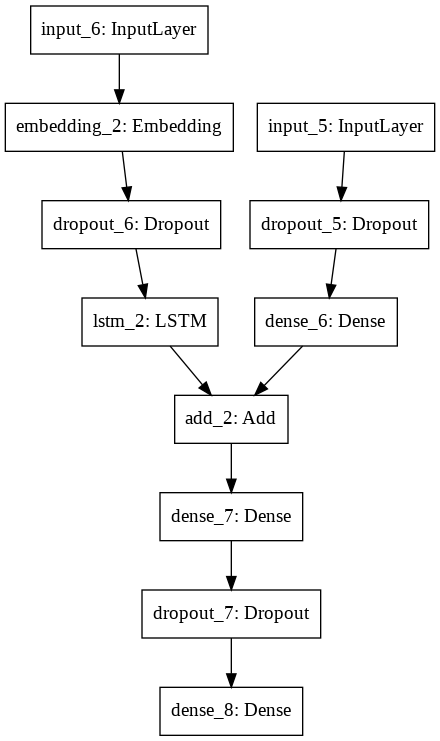

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model)

In [ ]:
############## LearningRateScheduler ##############
#lr = 0.012
def exp_decay(epoch):
    k = -0.05
    return lr*np.exp(k*epoch)
cb_lrSched = LearningRateScheduler(exp_decay, verbose=1)
############## EarlyStopping ##############
early_stopping = EarlyStopping(monitor='accuracy', patience=20, mode='max', restore_best_weights=True)

In [ ]:
#Compilamos el modelo.
epochs = 50
number_pics_per_batch = 32
steps = len(train_captions)//number_pics_per_batch
lr = 0.0012
adam = optimizers.Adam(learning_rate=lr )
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print('steps by generator:',steps)

steps by generator: 202


In [ ]:
#Realizamos el entrenamiento.
for i in range(epochs):
    print("\nEpochs {} de {} ...".format(i+1,epochs))
    #Utilizamos la función data_generator para generar la información de entrenamiento "en linea", es decir, durante el entrenamiento de manera temporal.
    generator = data_generator(train_captions, train_images, word2index, max_caption_voc, number_pics_per_batch)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[early_stopping])


Epochs 1 de 50 ...
202/202 [==============================] - 30s 147ms/step - loss: 2.8015 - accuracy: 0.3536

Epochs 2 de 50 ...
202/202 [==============================] - 30s 148ms/step - loss: 2.7991 - accuracy: 0.3540

Epochs 3 de 50 ...
202/202 [==============================] - 30s 148ms/step - loss: 2.7951 - accuracy: 0.3541

Epochs 4 de 50 ...
202/202 [==============================] - 31s 152ms/step - loss: 2.7883 - accuracy: 0.3557

Epochs 5 de 50 ...
202/202 [==============================] - 30s 151ms/step - loss: 2.7860 - accuracy: 0.3553

Epochs 6 de 50 ...
202/202 [==============================] - 30s 147ms/step - loss: 2.7829 - accuracy: 0.3552

Epochs 7 de 50 ...
202/202 [==============================] - 31s 155ms/step - loss: 2.7825 - accuracy: 0.3556

Epochs 8 de 50 ...
202/202 [==============================] - 31s 152ms/step - loss: 2.7800 - accuracy: 0.3560

Epochs 9 de 50 ...
202/202 [==============================] - 30s 148ms/step - loss: 2.7752 - accuracy:

#### **5.3 Almacenamiento de Modelo de Inferencia.**

In [ ]:
path_models = '/gdrive/My Drive/Cursos Personales/DIPLOMADO IA-PUCP/9. Series Temporales/Proyecto Final_Image Caption/KFC/models/'
filename = 'image_caption_inception_03.h5'  
## _01.h5 : es sin dropout con 200 epocas y lr de 0.05
## _02.h5 : es sin dropout con 100 epocas y lr de 0.05

In [ ]:
%%time
# Save the entire model to a HDF5 file.
model.save(path_models + filename)

CPU times: user 52.6 ms, sys: 14.7 ms, total: 67.2 ms
Wall time: 545 ms


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model_load = load_model(path_models + filename)
# Show the model architecture
model_load.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 300)      669600      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_5[0][0]                    
_______________________________________________________________________________________

#### **6. Generar Predicciones.**

In [ ]:
#Función para generar el texto a partir de la predicción de la red.
def get_caption_prediction(model, photo):
    in_text = 'startseq'
    for i in range(len(relevant_vocabulary)):
        sequence = [word2index[w] for w in in_text.split() if w in word2index]
        sequence = pad_sequences([sequence], maxlen=max_caption_voc)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index2word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
#Función para mostrar resultados de imágen y caption predicho.
def show_img_result(model, name_image):

    for i,desc in enumerate(descriptions[name_image]):
        desc = ' '.join(desc.split()[1:-1])
        print('Caption {}: {}'.format(i+1,desc))

    vecImage = images[name_image]
    vecImage =  vecImage[None]
    
    caption_pred = get_caption_prediction(model=model, photo = vecImage)

    img = Image.open(path_root+'/Images/'+name_image)
    plt.figure(figsize=(8,8))
    plt.imshow(img) 
    plt.axis('off')
    plt.title('Prediction: {}'.format(caption_pred))
    plt.show() 

In [ ]:
name_image = '3203878596_cbb307ce3b.jpg'
vecImage = images[name_image]
vecImage =  vecImage[None]
img_capt_pred = get_caption_prediction(model=model_load, photo = vecImage)
img_capt_pred

'two dogs are running through the snow'

Caption 1: two brown dogs are playing with each other in the snow
Caption 2: two brown dogs chase each other in the snow
Caption 3: two brown dogs play in the snow
Caption 4: two dogs playing in the snow
Caption 5: two dogs playing or fighting in the snow


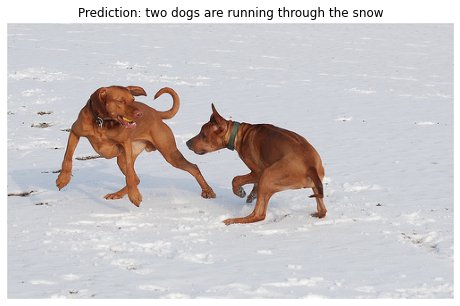

In [ ]:
show_img_result(model_load, name_image)


- Review 1 : (3325129757_7a1979ac11.jpg)
Caption 1: guy is watching another guy jump in the air while snowboarding
Caption 2: person in orange pants is doing tricks on snowboard while person in yellow cap watches
Caption 3: person sits on snowbank watching snowboarder take high leap
Caption 4: person watches as snowboarder does fancy trick in the air
Caption 5: snowboarder performing trick high in the air in snowy area


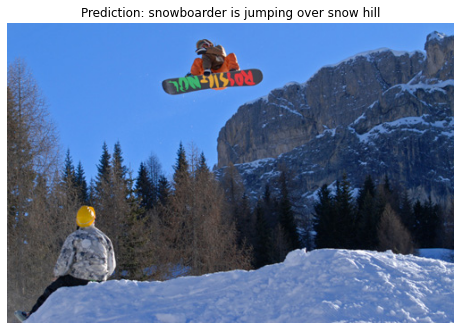


- Review 2 : (3260191163_6c1551eee8.jpg)
Caption 1: two brown dogs are playing in field
Caption 2: two brown dogs are wrestling in grassy field
Caption 3: two brown dogs play or fight
Caption 4: two dogs run across the grassy field
Caption 5: two large brown dogs run along field playfully


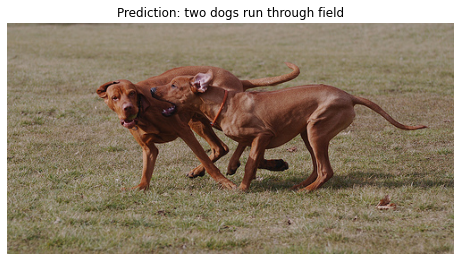


- Review 3 : (3317073508_7e13565c1b.jpg)
Caption 1: bunch of people playing soccer
Caption 2: action photo of soccer players in red and black uniforms
Caption 3: soccer player jumping in air during game
Caption 4: six soccer players on field with player in red uniform in the air and ball airborne
Caption 5: the red team knocked the ball toward the goal and the black team tried to block it


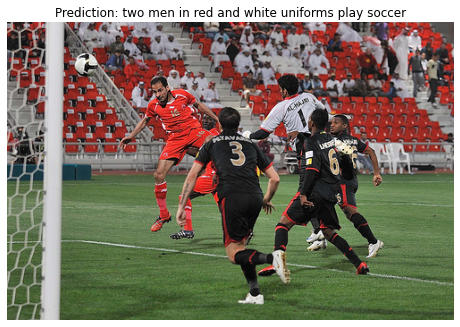


- Review 4 : (3540416139_c884f38351.jpg)
Caption 1: dog chases toy in the grass with its owner in the background
Caption 2: dog chases white animal on green lawn
Caption 3: dog playing outside in the grass
Caption 4: golden dog is running across the grass chasing white toy on the ground
Caption 5: the brown dog is running outside on the grass


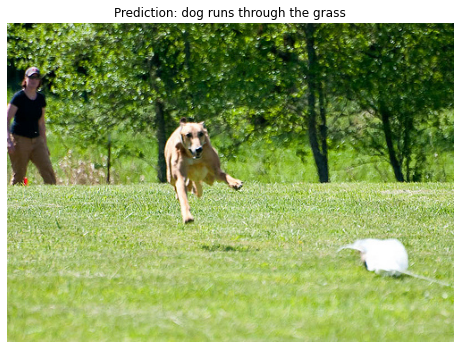


- Review 5 : (3135504530_0f4130d8f8.jpg)
Caption 1: one girl is wearing white with red sleeves the other has words on hers
Caption 2: two asian girls laughing together
Caption 3: two girls with dark hair and white shirts
Caption 4: two girls with long hair are smiling and one is hold something white and green
Caption 5: two women in white shirts talking


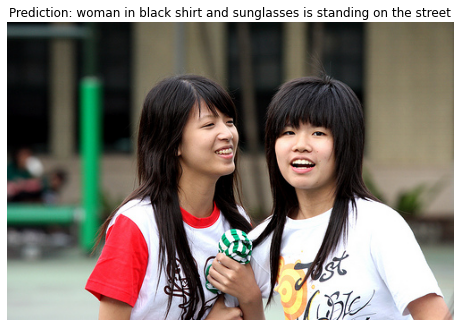


- Review 6 : (134894450_dadea45d65.jpg)
Caption 1: boy wearing no shirt and some blue jeans is jumping in the air in the woods
Caption 2: guy leaps into the air in wooded area
Caption 3: shirtless man jumps in sunny forest
Caption 4: shirtless man jumps over log
Caption 5: the boy is jumping in the woods


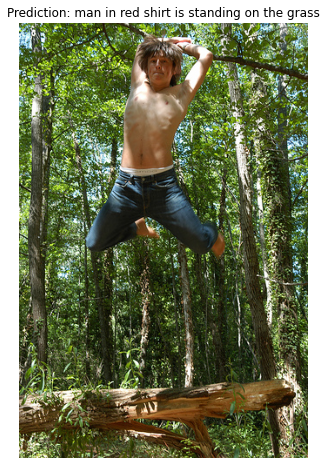


- Review 7 : (2428086758_bce4733f7e.jpg)
Caption 1: big brown dog sniffs smaller dog in the gravel beside body of water
Caption 2: big dog stiffing smaller dog near the edge of river
Caption 3: large dog stands with smaller dog near the edge of the water
Caption 4: red dog looks at brown dog on dirt path next to lake
Caption 5: the big dog is checking out the smaller dog


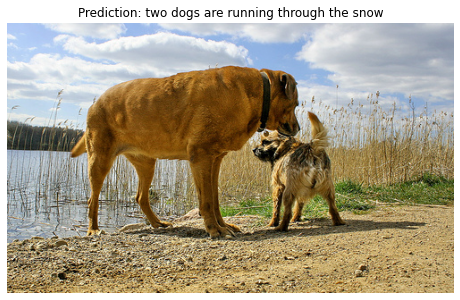


- Review 8 : (3250593457_9049a73b61.jpg)
Caption 1: child in striped dress and woman in black dress
Caption 2: little girl in striped dress has pink scarf
Caption 3: woman holding small child
Caption 4: woman with toddler in striped dress
Caption 5: the woman is holding baby girl wearing striped dress


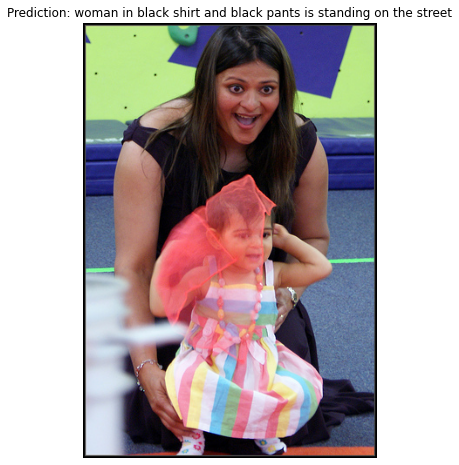


- Review 9 : (2473689180_e9d8fd656a.jpg)
Caption 1: man jet boarding
Caption 2: parasurfer is airborne over the water
Caption 3: wakeboarder is attempting trick while holding on to lines pointed upward
Caption 4: wakeboarder is jumping huge wave
Caption 5: person on wakeboard in the air


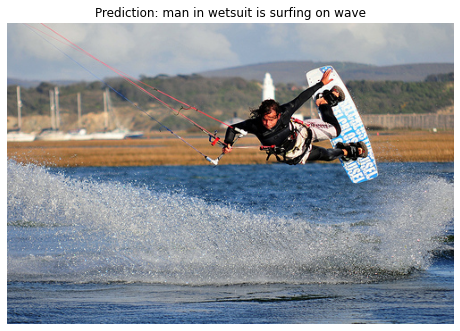


- Review 10 : (3331190056_09f4ca9fd2.jpg)
Caption 1: one white boy and one black boy stand with arms around each other
Caption 2: two boys one black and one white standing arm in arm
Caption 3: two boys put their arms around each other and pose
Caption 4: two young boys one white and one black are standing with their arms around each other
Caption 5: two young boys with their arms around one another


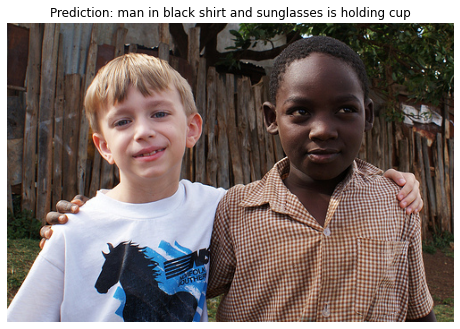

In [ ]:
#Realizamos pruebas sobre el dataset de "Train":
caption_review = list(train_images.keys())
caption_review = list(np.random.choice(caption_review, 10))

for i,title in enumerate(caption_review):
    print('\n- Review {} : ({})'.format(i+1,title))
    show_img_result(model_load, name_image = title)


- Review 1 : (3154709407_9b0778cbeb.jpg)
Caption 1: bald man dribbles basketball while wearing miami jersey
Caption 2: man playing basketball jersey number
Caption 3: number five plays basketball for miami
Caption 4: the basketball player is wearing orange sneakers
Caption 5: the number five miami player dribbles down the court


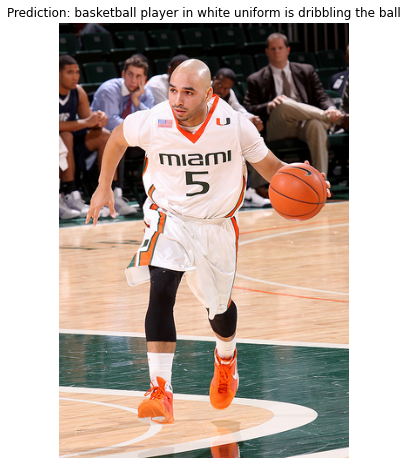


- Review 2 : (2687229880_97cfd8148e.jpg)
Caption 1: woman in is walking holding silver cellphone
Caption 2: woman in black shirt walking down the street
Caption 3: woman wearing black shirt walks among crowd in city
Caption 4: brunette woman in black walking through blurred crowd
Caption 5: lady walking and squinting from the sun in large group of people


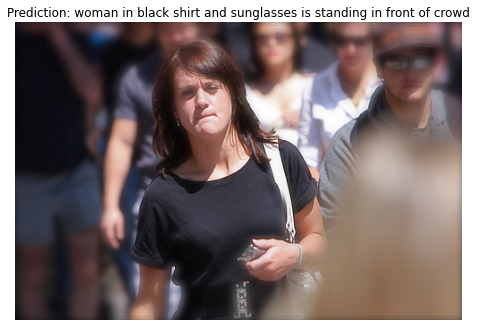


- Review 3 : (3003691049_f4363c2d5c.jpg)
Caption 1: dog corners little girl next to police cruiser
Caption 2: girl playing with dog near police car
Caption 3: large white dog girl and police car in driveway and an suv in garage
Caption 4: little girl is playing with large white poodle in the driveway next to police car
Caption 5: the girl is playing with her dog in her driveway


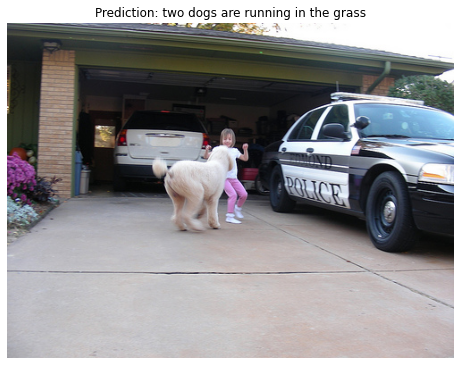


- Review 4 : (1304100320_c8990a1539.jpg)
Caption 1: the two dogs are running through field of flowers
Caption 2: two dogs are running through field of pink flowers
Caption 3: two dogs bound over hill
Caption 4: two dogs playing in misty field filled with purple flowers
Caption 5: two gray dogs run through field of pink heather


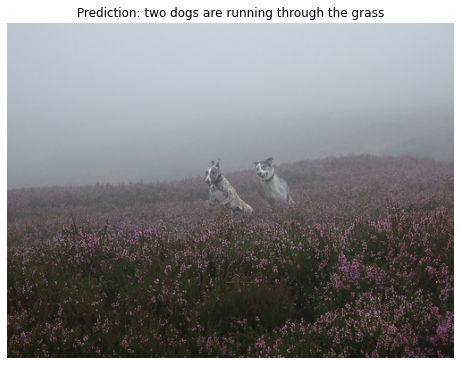


- Review 5 : (3649224118_abe73c672c.jpg)
Caption 1: group of guys are playing soccer on the beach
Caption 2: men playing soccer on red sand
Caption 3: several people on beach and ball
Caption 4: they are playing with soccer ball on the beach
Caption 5: two young men play soccer on the beach


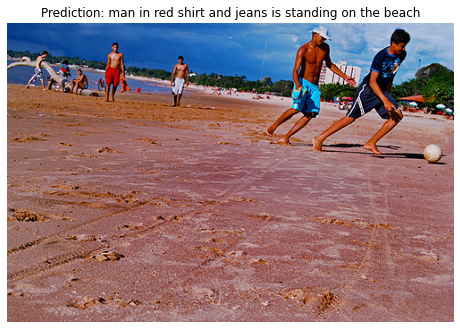


- Review 6 : (1424775129_ffea9c13ab.jpg)
Caption 1: little boy walking on railroad tracks
Caption 2: little boy walks along railroad tracks in the woods
Caption 3: little boy walking with stick on tracks
Caption 4: the little boy walks along the railroad tracks with his stick
Caption 5: there is little boy in red jacket walking down the railroad tracks and holding stick


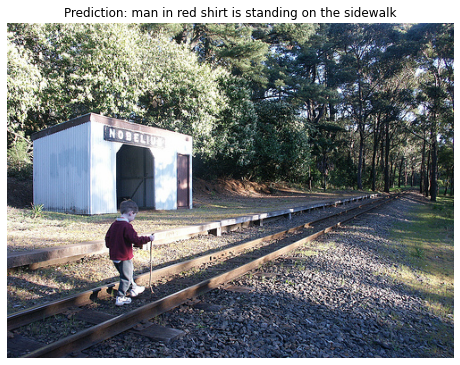


- Review 7 : (2787276494_82703f570a.jpg)
Caption 1: little boy in green goggles and white life jacket jumps into the water
Caption 2: little boy in red shorts jumps into the water
Caption 3: person jumps off of ledge into body of water
Caption 4: boy with life jacket jumping into water
Caption 5: guy with ski jacket jumping off bridge into water


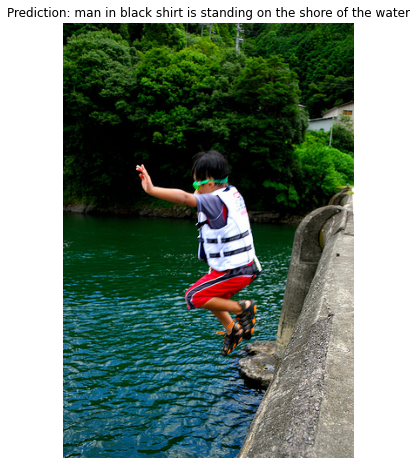


- Review 8 : (2733659177_d74a00995b.jpg)
Caption 1: blond child is laying on branch of tree in green field
Caption 2: boy wearing yellow shirt and blue pants is climbing large fallen tree limb outdoors in grassy meadow
Caption 3: boy wearing yellow shirt and blue pants is climbing tree in hilly area
Caption 4: boy wearing yellow shirt and blue pants is climbing on tree branch in grassy field
Caption 5: young boy climbing tree in grassy hills


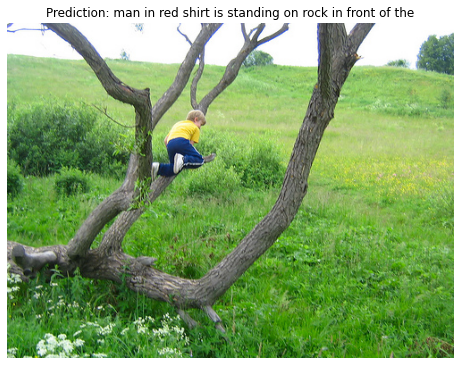


- Review 9 : (2519812011_f85c3b5cb5.jpg)
Caption 1: couple people running through large sidewalk fountain
Caption 2: young boy is running through water fountain
Caption 3: children are under large fountain in the city
Caption 4: child runs through city fountain
Caption 5: some children run through fountain


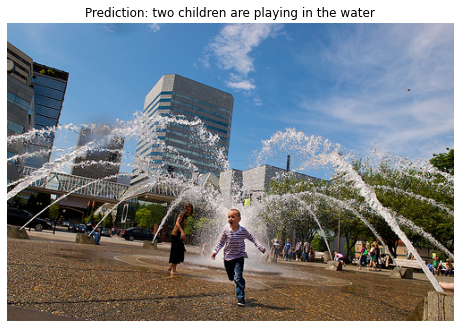


- Review 10 : (3397310901_cbef5c06ef.jpg)
Caption 1: bicyclist rides on ramps
Caption 2: bike rider does trick in the air
Caption 3: man performs bike trick on ramp
Caption 4: extreme bmx rider defying gravity
Caption 5: person doing tricks on bicycle in skatepark


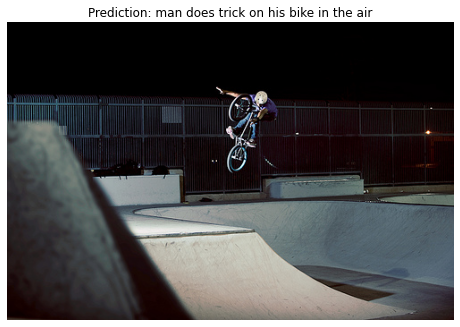

In [ ]:
#Realizamos pruebas sobre el dataset de Test:
caption_review = list(test_images.keys())
caption_review = list(np.random.choice(caption_review, 10))

for i,title in enumerate(caption_review):
    print('\n- Review {} : ({})'.format(i+1,title))
    show_img_result(model_load, name_image = title)